# Análisis no supervisado de Licitaciones

Se buscará encontrar comportamientos dentro de las licitaciones para identificar anomalías.

## Variables 

- Comparación de fechas
- Montos (normalizados por licitación/categoría)
- Frecuencia de ganador
- Empresas ganadoras en más de un rubro
- Recurrencia de convenios modificatorios
- Monto de convenios modificatorios

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
lic = pd.read_csv('data/raw/Copia de AGOSTO COMPRAS MUNICIPALES 2016-2019-SOCIAL TIC.xlsx - Compras.csv')

### Extracción de datos

In [3]:
datos = (
    pd.DataFrame()
    .assign(
        dep = lic['DEPENDENCIA SOLICITANTES'],
        proveedor = lic['PROVEEDOR'],
        cat = lic['CATEGORÍA '],
        sub_cat = lic['SUBCATEGORÍA'],
        comienzo_admon = lic['AÑO DE INICIO DE LA ADMINISTRACIÓN'],
        fin_admon = lic['AÑO DE TÉRMINO DE LA ADMINISTRACIÓN'],
        ejercicio = lic['EJERCICIO'],
        inicio_contrato = pd.to_datetime(lic['PERIODO DE CONTRATO: INICIO'],format='%m/%d/%Y', errors='coerce'),
        fin_contrato = pd.to_datetime(lic['PERIODO DE CONTRATO: TERMINACIÓN'],format='%m/%d/%Y', errors='coerce'),
        fecha_contrato = pd.to_datetime(lic['FECHA DE CONTRATO'],format='%m/%d/%Y', errors='coerce'),
        fecha_lic = pd.to_datetime(lic['ACTA ORIGINAL / FECHA'],format='%m/%d/%Y', errors='coerce'),
        monto_original = lic['MONTO ORIGINAL']
            .str.extractall('(\d*)')
            .fillna('').reset_index()
            .groupby(['level_0'])[0].apply(lambda x: ''.join(x)).astype(int)/100,
        monto_adicional = lic['CONVENIO MODIFICATORIO / MONTO ADICIONAL']
            .str.extractall('(\d*)')
            .fillna('').reset_index()
            .groupby(['level_0'])[0].apply(lambda x: ''.join(x))
            .astype(int)/100,
    )
)
datos.sample(5)

,dep,proveedor,cat,sub_cat,comienzo_admon,fin_admon,ejercicio,inicio_contrato,fin_contrato,fecha_contrato,fecha_lic,monto_original,monto_adicional
261,DIRECCIÓN GENERAL DE TRÁNSITO MUNICIPAL,"CNC RECYCLING, S. DE R.L. DE C.V.",TELECOMUNICACIONES,TELECOMUNICACIONES,2016.0,2018.0,2017,2017-03-08,2017-12-31,2017-03-08,2017-03-07,10000000.00,NaN
636,DIRECCIÓN GENERAL DE OBRAS PÚBLICAS,C. MANUEL DAVID RICO RASCÓN,PAVIMENTACIÓN,Pavimentación,2016.0,2018.0,2017,2017-10-10,2017-12-28,2017-09-27,2017-08-16,1915104.73,NaN
272,DIRECCIÓN GENERAL DE TRÁNSITO MUNICIPAL,"COMEDORES Y SERVICIOS DE CHIHUAHUA I, S.A DE C.V.",ALIMENTOS: ACADEMIAS POLICÍA / TRÁNSITO,ALIMENTOS ACADEMIA DE POLICÍAS,2016.0,2018.0,2017,2017-10-09,2017-12-31,2017-10-12,NaT,350000.00,NaN
34,COORDINACIÓN GENERAL DE COMUNICACIÓN SOCIAL,"MULTIMEDIOS, S.A. DE C.V.",PUBLICIDAD EN MEDIOS,PUBLICIDAD TELEVISIÓN,2016.0,2018.0,2017,2017-01-01,2017-12-31,2017-02-10,2017-02-09,2000000.00,NaN
430,SECRETARÍA DE SEGURIDAD PÚBLICA,"TACTICAL SOLUTIONS, S. DE R.L. DE C.V.",UNIFORMES,INSIGNIAS Y DIVISAS PARA PERSONAL DE SEGURIDAD...,2016.0,2018.0,2017,2017-11-17,2017-12-31,2017-11-17,NaT,583200.00,NaN


### Creación de variables

In [4]:
# tfidf proveedores vs categorías

docs = (
    datos
    .assign(prov=lambda x: x.proveedor.str.replace(' ', '_').str.replace(',', '_').str.replace('.', '_').astype(str))
    .groupby('cat')
    .prov
    .apply(lambda x: ' '.join(x))
)

tfidf = TfidfVectorizer()
tfidf.fit(docs)

X = (
    pd.DataFrame.from_dict(
        dict(tfidf.transform(docs).todok()),
             orient='index').reset_index().assign(
            row=lambda x: x['index'].str[0],
            col=lambda x: x['index'].str[1]).assign(
            prov=lambda x: x.col.apply(lambda y: list(tfidf.get_feature_names())[y]),
            cat=lambda x: x.row.apply(lambda y: list(docs.index)[y])
        ).rename(columns={0: 'tfidf'})
    [['prov','tfidf','cat']]
    .merge(
        datos
        .assign(prov=lambda x: x.proveedor.str.replace(' ', '_').str.replace(',', '_').str.replace('.', '_').str.lower().astype(str)))
    .drop(columns=['prov'])
)
X.head()

,tfidf,cat,dep,proveedor,sub_cat,comienzo_admon,fin_admon,ejercicio,inicio_contrato,fin_contrato,fecha_contrato,fecha_lic,monto_original,monto_adicional
0,0.157412,PUBLICIDAD EN MEDIOS,COORDINACIÓN GENERAL DE COMUNICACIÓN SOCIAL,"26 DE MÉXICO, S. DE R.L. DE C.V.",PUBLICIDAD TELEVISIÓN,2018.0,2021.0,2019,2019-02-11,2019-12-31,2019-02-11,2019-02-11,1000000.0,NaN
1,0.157412,PUBLICIDAD EN MEDIOS,COORDINACIÓN GENERAL DE COMUNICACIÓN SOCIAL,"26 DE MÉXICO, S. DE R.L. DE C.V.",PUBLICIDAD TELEVISIÓN,2016.0,2018.0,2018,2018-01-01,2018-08-31,2018-02-02,2018-02-02,720000.0,NaN
2,0.157412,PUBLICIDAD EN MEDIOS,COORDINACIÓN GENERAL DE COMUNICACIÓN SOCIAL,"26 DE MÉXICO, S. DE R.L. DE C.V.",PUBLICIDAD RADIO / TELEVISIÓN,2016.0,2018.0,2017,2017-01-01,2017-12-31,2017-04-07,2017-04-07,790000.0,NaN
3,0.108170,VEHÍCULOS,SECRETARÍA DE SEGURIDAD PÚBLICA,"399 PROJEY DEVELOPMENT, S.A. DE C.V.",VEHÍCULOS,2018.0,2021.0,2018,2018-12-20,2018-12-31,2018-12-20,NaT,3572800.0,NaN
4,0.342677,COMUNICACIÓN,COORDINACIÓN GENERAL DE COMUNICACIÓN SOCIAL,"AB ESTUDIO DE COMUNICACIÓN, S.A. DE C.V.",ENCUESTA Y ESTUDIO DE OPINIÓN,2016.0,2018.0,2018,2018-01-01,2018-08-31,2018-01-12,2018-01-12,2000000.0,NaN


In [5]:
(X.fin_admon+1).astype(str).str.replace('\.0', '')+"0101"

0      20220101
1      20190101
2      20190101
3      20220101
4      20190101
5      20220101
6      20190101
7      20190101
8      20190101
9      20190101
10     20190101
11     20190101
12     20190101
13     20190101
14     20190101
15     20190101
16     20190101
17     20190101
18     20190101
19     20190101
20      nan0101
21     20190101
22     20190101
23     20190101
24      nan0101
25      nan0101
26      nan0101
27     20190101
28     20190101
29     20190101
         ...   
876    20190101
877    20190101
878    20190101
879    20190101
880    20190101
881    20190101
882    20190101
883    20190101
884    20190101
885    20190101
886    20190101
887    20190101
888    20190101
889    20190101
890     nan0101
891    20190101
892    20190101
893    20190101
894    20190101
895    20190101
896    20190101
897    20190101
898    20190101
899    20220101
900     nan0101
901     nan0101
902     nan0101
903    20190101
904    20190101
905    20190101
Name: fin_admon, Length:

In [50]:
X_eng = (
    X
    .assign(duracion_contrato = lambda x: (x.fin_contrato - x.inicio_contrato).dt.days)
    .assign(duracion_contrato_std=lambda x: (x.duracion_contrato-x.duracion_contrato.mean())/
            x.duracion_contrato.std())
#     .assign(porc_dentro_admon = lambda x: 
#             ((pd.to_datetime((x.fin_admon+1).astype(str).str.replace('\.0', '')+"0101",errors='coerce') - x.inicio_contrato).dt.days / x.duracion_contrato)
#            .apply(lambda y: min(y,1)))
    .assign(freq_gan=lambda x: x.groupby('proveedor').cat.transform('count').fillna(0).apply(lambda y: np.log(y+1)))
    .assign(freq_gan_std=lambda x: (x.freq_gan-x.freq_gan.mean())/x.freq_gan.std())
    .assign(num_rubros=lambda x: x.groupby(['proveedor']).cat.transform('nunique').fillna(0))
    .assign(num_rubros_std=lambda x: (x.num_rubros-x.num_rubros.mean())/x.num_rubros.std())
    .assign(monto_final=lambda x: x.monto_original + x.monto_adicional.fillna(0))
    .assign(monto_norm_cat=lambda x: (x.monto_final - x.groupby('cat').monto_final.transform('mean'))/
            x.groupby('cat').monto_final.transform('std').fillna(1))
)
X_eng

,tfidf,cat,dep,proveedor,sub_cat,comienzo_admon,fin_admon,ejercicio,inicio_contrato,fin_contrato,...,monto_original,monto_adicional,duracion_contrato,duracion_contrato_std,freq_gan,freq_gan_std,num_rubros,num_rubros_std,monto_final,monto_norm_cat
0,0.157412,PUBLICIDAD EN MEDIOS,COORDINACIÓN GENERAL DE COMUNICACIÓN SOCIAL,"26 DE MÉXICO, S. DE R.L. DE C.V.",PUBLICIDAD TELEVISIÓN,2018.0,2021.0,2019,2019-02-11,2019-12-31,...,1000000.00,NaN,323.0,1.293161,1.386294,-0.198612,1.0,-0.698525,1000000.00,-0.216201
1,0.157412,PUBLICIDAD EN MEDIOS,COORDINACIÓN GENERAL DE COMUNICACIÓN SOCIAL,"26 DE MÉXICO, S. DE R.L. DE C.V.",PUBLICIDAD TELEVISIÓN,2016.0,2018.0,2018,2018-01-01,2018-08-31,...,720000.00,NaN,242.0,0.677785,1.386294,-0.198612,1.0,-0.698525,720000.00,-0.337209
2,0.157412,PUBLICIDAD EN MEDIOS,COORDINACIÓN GENERAL DE COMUNICACIÓN SOCIAL,"26 DE MÉXICO, S. DE R.L. DE C.V.",PUBLICIDAD RADIO / TELEVISIÓN,2016.0,2018.0,2017,2017-01-01,2017-12-31,...,790000.00,NaN,364.0,1.604648,1.386294,-0.198612,1.0,-0.698525,790000.00,-0.306957
3,0.108170,VEHÍCULOS,SECRETARÍA DE SEGURIDAD PÚBLICA,"399 PROJEY DEVELOPMENT, S.A. DE C.V.",VEHÍCULOS,2018.0,2021.0,2018,2018-12-20,2018-12-31,...,3572800.00,NaN,11.0,-1.077179,0.693147,-1.290195,1.0,-0.698525,3572800.00,-0.250840
4,0.342677,COMUNICACIÓN,COORDINACIÓN GENERAL DE COMUNICACIÓN SOCIAL,"AB ESTUDIO DE COMUNICACIÓN, S.A. DE C.V.",ENCUESTA Y ESTUDIO DE OPINIÓN,2016.0,2018.0,2018,2018-01-01,2018-08-31,...,2000000.00,NaN,242.0,0.677785,1.386294,-0.198612,1.0,-0.698525,2000000.00,0.691936
5,0.342677,COMUNICACIÓN,COORDINACIÓN GENERAL DE COMUNICACIÓN SOCIAL,"AB ESTUDIO DE COMUNICACIÓN, S.A. DE C.V.",ENCUESTA Y ESTUDIO DE OPINIÓN,2018.0,2021.0,2018,2018-11-01,2018-12-31,...,750000.00,NaN,60.0,-0.704914,1.386294,-0.198612,1.0,-0.698525,750000.00,-0.577310
6,0.342677,COMUNICACIÓN,COORDINACIÓN GENERAL DE COMUNICACIÓN SOCIAL,"AB ESTUDIO DE COMUNICACIÓN, S.A. DE C.V.",ENCUESTA Y ESTUDIO DE OPINIÓN,2016.0,2018.0,2017,2017-01-01,2017-12-31,...,3000000.00,NaN,364.0,1.604648,1.386294,-0.198612,1.0,-0.698525,3000000.00,1.707333
7,0.381906,CUARTOS ROSAS / INDEPENDIENTES,DIRECCIÓN GENERAL DE OBRAS PÚBLICAS,"ABBUD Y ASOCIADOS CONSTRUCCIONES, S.A. DE C.V.",CONSTRUCCIÓN DE CUARTOS,2016.0,2018.0,2018,2018-06-01,2018-08-29,...,10993874.48,NaN,89.0,-0.484594,2.079442,0.892970,3.0,0.817317,10993874.48,-0.198380
8,0.381906,CUARTOS ROSAS / INDEPENDIENTES,DIRECCIÓN GENERAL DE OBRAS PÚBLICAS,"ABBUD Y ASOCIADOS CONSTRUCCIONES, S.A. DE C.V.",CONSTRUCCIÓN DE CUARTOS,2016.0,2018.0,2018,2018-07-31,2018-08-31,...,10985385.60,NaN,31.0,-0.925234,2.079442,0.892970,3.0,0.817317,10985385.60,-0.201607
9,0.381906,CUARTOS ROSAS / INDEPENDIENTES,DIRECCIÓN GENERAL DE OBRAS PÚBLICAS,"ABBUD Y ASOCIADOS CONSTRUCCIONES, S.A. DE C.V.",CONSTRUCCIÓN DE CUARTOS,2016.0,2018.0,2017,2017-10-10,2017-12-28,...,13885218.56,NaN,79.0,-0.560566,2.079442,0.892970,3.0,0.817317,13885218.56,0.900978


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efe87be2c18>,
      dtype=object)

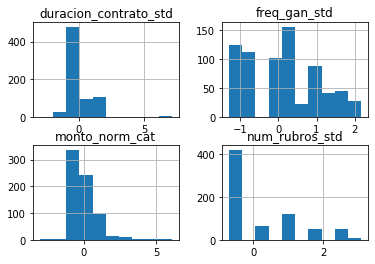

In [70]:
X_std = X_eng[['dep', 'duracion_contrato_std',
  'freq_gan_std',
  'num_rubros_std',
  'monto_norm_cat']].dropna()
X_std.hist()
# X_std = X_std - mean()

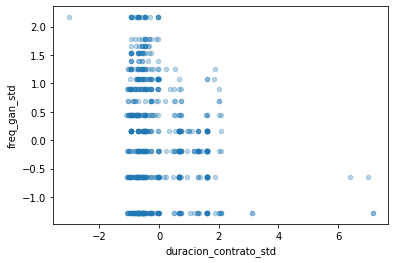

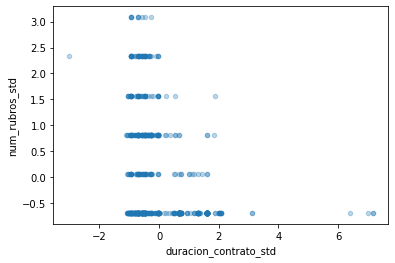

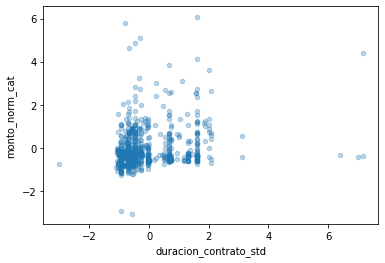

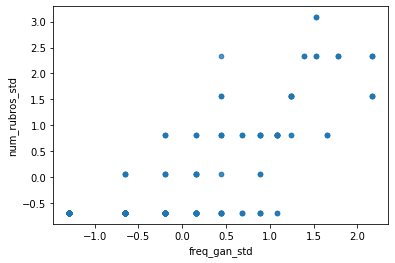

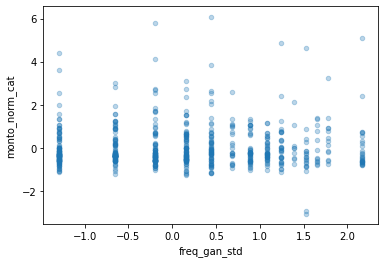

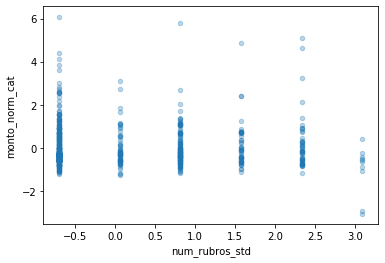

In [71]:
X_std.plot.scatter(x='duracion_contrato_std', y='freq_gan_std', alpha=0.3)
plt.show()
X_std.plot.scatter(x='duracion_contrato_std', y='num_rubros_std', alpha=0.3)
plt.show()
X_std.plot.scatter(x='duracion_contrato_std', y='monto_norm_cat', alpha=0.3)
plt.show()
X_std.plot.scatter(x='freq_gan_std', y='num_rubros_std', alpha=0.3)
plt.show()
X_std.plot.scatter(x='freq_gan_std', y='monto_norm_cat', alpha=0.3)
plt.show()
X_std.plot.scatter(x='num_rubros_std', y='monto_norm_cat', alpha=0.3)
plt.show()

In [72]:
tsne = TSNE(n_components=2)
tsne.fit(X_std.iloc[:,1:])

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
     method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
     n_components=2, n_iter=1000, n_iter_without_progress=300, perplexity=30.0,
     random_state=None, verbose=0)

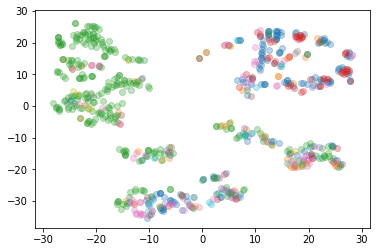

In [73]:
for c in X_std.iloc[:,0].unique():
    plt.scatter(tsne.embedding_[X_std.iloc[:,0]==c,0], tsne.embedding_[X_std.iloc[:,0]==c,1], alpha=0.3)
plt.show()

In [74]:
X_std.dep.value_counts()

DIRECCIÓN GENERAL DE OBRAS PÚBLICAS                                  295
COORDINACIÓN GENERAL DE COMUNICACIÓN SOCIAL                          151
DIRECCIÓN DE RECURSOS MATERIALES                                      49
SECRETARÍA DE SEGURIDAD PÚBLICA                                       30
DIRECCIÓN DE MANTENIMIENTO MECÁNICO                                   27
OFICIALÍA MAYOR                                                       26
SECRETARÍA DEL AYUNTAMIENTO                                           21
DIRECCIÓN GENERAL DE SERVICIOS PÚBLICOS                               17
DIRECCIÓN GENERAL DE TRÁNSITO MUNICIPAL                               16
TESORERÍA MUNICIPAL                                                   12
DIRECCIÓN GENERAL DE DESARROLLO SOCIAL                                 9
SECRETARÍA PARTICULAR                                                  7
DIRECCIÓN GENERAL DE PLANEACIÓN Y EVALUACIÓN                           6
ADMINISTRADOR DE LA CIUDAD                         